<a href="https://colab.research.google.com/github/JairEsc/Mat_Apl_2/blob/main/Tesis_redes_arbol_exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

Podemos calcular antes de la simulación los tiempos de contacto y recuperación de cada individuo. Estos tiempos definen una red direccionada con pesos, y podemos conocer a cada instante el estado de la población considerada. 

Me gustaría hacer un código para ilustrar lo anterior. 

Sean $\beta$, $\gamma$ constantes y conocidas. 
Sea $N$ conocido el número de individuos en la población y sea $G=(V,E)$ la gráfica conexa de tipo arbol que modela su interacción. 

Obtenemos $(r_i)_{i=1}^N$ una sucesión de tiempos de recuperación para cada individuo. Es decir, una vez que se infecte (si es que lo hace), estará en el estado infecciosos durante $r_i$ unidades de tiempo. 

A su vez, para cada individuo $i$, denotando por $\mathcal{N}(i)$ al conjunto de nodos adyacentes a $i$, calculamos sus tiempos de contacto $(c_j^{(i)})_{j=1}^{\mathcal{N}(i)}$ con cada uno de sus vecinos. Es decir, cuando el individuo se infecta (si es que lo hace), sabemos que en $c_j^{(i)}$ unidades de tiempo tendrá un contacto con el individuo $j$, que podría o no ser susceptible. 

Cuando ocurre que $j$ es susceptible y que el tiempo de recuperación de $i$ es mayor que el tiempo de contacto con $j$, tenemos una infección en el individuo $j$ a través del contacto $(i,j)\in E$.

Supongamos que al inicio de la epidemia hay un único individuo infectado $i_0$, sabemos que el individuo $j$, el cual no necesariamente es adyacente a $i$ no puede ser susceptible al tiempo $t$ si ocurre una de las siguientes 2 posibilidades: 
$j$ es uno de los individuos infectados al tiempor $t=0$ o, 
Existe un camino de longitud menor que $t$ desde $j$ a un nodo infectado al tiempo $t=0$


Nota. Esto funciona bien por la propiedad de pérdida de memoria de la exponencial. Específicamente, cuando obtenemos los tiempos de contacto imediatamente después de una infección, estamos suponiendo que no importa el tiempo en el que se infecta el nodo, solo importa el tiempo que tarde antes del primer contacto.

In [2]:
import numpy as np
import scipy.stats 

In [3]:
#Parámetros
beta=8/9
gamma=2/9

In [6]:
N=10#Numero de nodos
np.random.seed(1)#Fijamos semilla
G_rand=nx.random_tree(N,)#Red de tipo arbol.
recuperation_times=np.random.exponential(scale=1/gamma,size=N)#Tiempos de recuperacion exponencial
contact_times=nx.to_numpy_matrix(G_rand)
for i in range(contact_times.shape[0]):
    for j in range(i,contact_times.shape[1]):#Triangular superior asumiendo contacto $i->j$ equivalente a contacto $j->i$
        if(contact_times[i,j]!=0.):
            contact_times[i,j]=round(np.random.exponential(scale=1/beta),3)

Evolución en el tiempo.

Se puede considerar discretizado y graficar en cada tiempo de "cambio"

Asumimos el nodo 0 como el único inicialmente infectado.

In [10]:
def update_graph(G0, color_map):
    pos=nx.spring_layout(G0,seed=0,k=5)
    labels = nx.get_edge_attributes(G0,'weight',)
    nx.draw(G0,pos, node_color=color_map, with_labels=True)
    nx.draw_networkx_edge_labels(G0,pos,edge_labels=labels)
    plt.draw()
    display.display(plt.gcf())
    display.clear_output(wait=True)
    sleep(1)

4.278


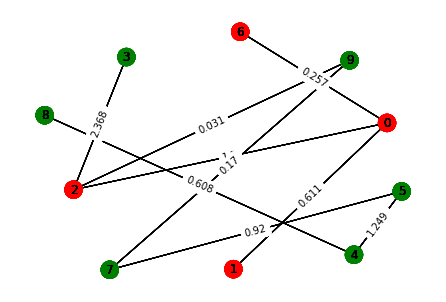

In [11]:
import matplotlib.pyplot as plt
from IPython import display
from time import sleep

G0=nx.from_numpy_matrix(contact_times.transpose())#Red inicial
G=nx.from_numpy_matrix(contact_times.transpose())#Red modificable

color_map_0=['red' if i==0 else 'green' for i in range(len(list(G.nodes)))]#Configuracion inicial
color_map=['red' if i==0 else 'green' for i in range(len(list(G.nodes)))]#Configuracion modificable

p=nx.shortest_path_length(G, source=0,weight='weight')#Calcula las longitudes más cortas de los caminos que inician en el paciente cero.
#Nota 1. En árboles existe un único camino entre cualesquiera dos vértices, en particular entre el paciente cero y $j$.
p_sec=nx.shortest_path(G, source=0,weight='weight')#Calcula los caminos más cortos del paciente cero a todos los demás nodos.
T=list(p.values())#En árboles esta discretización es exacta. En redes en general podemos actualizar el iterable del loop.
for t in T[0:]:#Agregar en T los tiempos de recuperacion y un tercer color para recuperados (pendiente)
    print(t)
    for j in list(G.nodes):#Iterable sobre todos los nodos
        try:
            boolean=t>=p[j] #Existe un camino de longitud menor que $t$ que conecta $j$ y el paciente 0. #Generalizable a que haya más de un paciente 0.
        except: boolean=False
        if color_map_0[j]!='red' and boolean:#$j$ no fue de los inicialmente infectados Y existe un camino de longitud menor que $t$ que lo conecta al ÚNICO paciente cero.
            #Aqui se pregunta si el tiempo de recuperacion del anterior es mayor que el tiempo de contacto
            prev=p_sec[j][-2]# 'prev' es  el nodo infeccioso que contagiaría a $j$ en ése camino más corto. 
            if G[prev][j]['weight']<recuperation_times[prev]:#Si el tiempo de contacto es menor que el tiempo de recuperación de 'prev', ocurre una infección.
                color_map[j]='red'
            else:
                G.remove_edge(prev,j)#Removemos esa arista porque el contacto no ocurre. En árboles, quitarlos es equivalente a desconectar nodos, 
                                        #en redes en general, quitarlos es modificar el conjunto de caminos y exlcuír el camino más corto (podría haber otro)
                p=nx.shortest_path_length(G, source=0,weight='weight')#Recalculamos los caminos más cortos.
                p_sec=nx.shortest_path(G, source=0,weight='weight')
                print('Hubo contacto pero no habia infeccion')
    #Graficamos.
    update_graph(G0,color_map)
print(T[-1])

Hasta aquí funciona para cualquier arbol aleatorio y distribuciones exponenciales. (Estoy concentrándome en el número de infectados sin preocuparme por los recuperados. Podrían obteerse creando un arreglo con los tiempos de infección y con ése, aplicar las distribuciones de recuperación para conocer las proporciones de infectados y recuperados.)

Ahora generalizemos a cualquier gráfica (Es decir, ahora se permiten ciclos.)

La manera en la que cambia será que ahora un individuo $j$ será infectado al tiempo $t$ si no fue uno de los pacientes cero (o el tiempo de recuperación es mayor que $t$) y si en la vecindad de radio $t$ existe un individuo $i$ que fue de los inicialmente infecciosos.



5.0


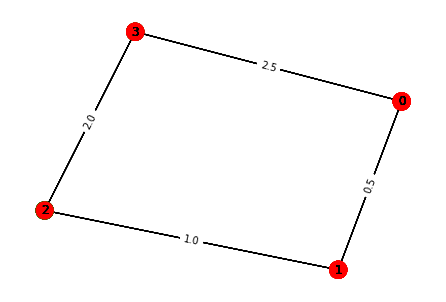

In [21]:
#Ejemplo 1. Red=Ciclo
t_01=0.5
t_12=1
t_23=2
t_30=2.5
Matrx_weights=np.array([[0,t_01,0,t_30],[t_01,0,t_12,0],[0,t_12,0,t_23],[t_30,0,t_23,0]])
G_c=nx.from_numpy_matrix(Matrx_weights,)
update_graph(G0=G_c,color_map=['g','g','g','g'])
recuperation_times=[3,0.01,0.01,2.01]
G0=nx.from_numpy_matrix(Matrx_weights.transpose())#Red inicial
G=nx.from_numpy_matrix(Matrx_weights.transpose())#Red modificable

color_map_0=['red' if i==0 else 'green' for i in range(len(list(G.nodes)))]#Configuracion inicial
color_map=['red' if i==0 else 'green' for i in range(len(list(G.nodes)))]#Configuracion modificable

p=nx.shortest_path_length(G, source=0,weight='weight')#Calcula las longitudes más cortas de los caminos que inician en el paciente cero.
#Nota 1. En árboles existe un único camino entre cualesquiera dos vértices, en particular entre el paciente cero y $j$.
p_sec=nx.shortest_path(G, source=0,weight='weight')#Calcula los caminos más cortos del paciente cero a todos los demás nodos.
T=np.linspace(0,5,10)#En árboles esta discretización es exacta. En redes en general podemos actualizar el iterable del loop.
for t in T[0:]:#Agregar en T los tiempos de recuperacion y un tercer color para recuperados (pendiente)
    print(t)
    for j in list(G.nodes):#Iterable sobre todos los nodos
        try:
            boolean=t>=p[j] #Existe un camino de longitud menor que $t$ que conecta $j$ y el paciente 0. #Generalizable a que haya más de un paciente 0.
        except: boolean=False
        if color_map_0[j]!='red' and boolean:#$j$ no fue de los inicialmente infectados Y existe un camino de longitud menor que $t$ que lo conecta al ÚNICO paciente cero.
            #Aqui se pregunta si el tiempo de recuperacion del anterior es mayor que el tiempo de contacto
            prev=p_sec[j][-2]# 'prev' es  el nodo infeccioso que contagiaría a $j$ en ése camino más corto. 
            if G[prev][j]['weight']<recuperation_times[prev]:#Si el tiempo de contacto es menor que el tiempo de recuperación de 'prev', ocurre una infección.
                color_map[j]='red'
            else:
                G.remove_edge(prev,j)#Removemos esa arista porque el contacto no ocurre. En árboles, quitarlos es equivalente a desconectar nodos, 
                                        #en redes en general, quitarlos es modificar el conjunto de caminos y exlcuír el camino más corto (podría haber otro)
                p=nx.shortest_path_length(G, source=0,weight='weight')#Recalculamos los caminos más cortos.
                p_sec=nx.shortest_path(G, source=0,weight='weight')
                print('Hubo contacto pero no habia infeccion')
    #Graficamos.
    update_graph(G0,color_map)
print(T[-1])

1.81


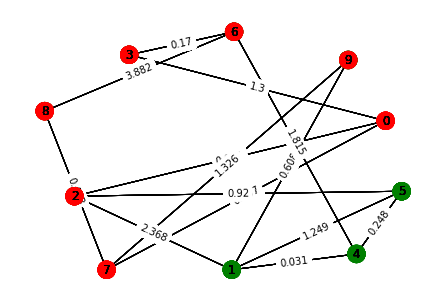

In [12]:
N=10
np.random.seed(1)
G_rand=nx.random_graphs.fast_gnp_random_graph(N,p=0.25)
recuperation_times=np.random.exponential(scale=1/gamma,size=N)
contact_times=nx.to_numpy_matrix(G_rand)
for i in range(contact_times.shape[0]):
    for j in range(i,contact_times.shape[1]):
        if(contact_times[i,j]!=0.):
            contact_times[i,j]=round(np.random.exponential(scale=1/beta),3)
import matplotlib.pyplot as plt
G0=nx.from_numpy_matrix(contact_times.transpose())#Red inicial
G=nx.from_numpy_matrix(contact_times.transpose())#Red modificable
from IPython import display
from time import sleep
color_map_0=['red' if i==0 else 'green' for i in range(len(list(G.nodes)))]#Configuracion inicial
color_map=['red' if i==0 else 'green' for i in range(len(list(G.nodes)))]#Configuracion modificable
p=nx.shortest_path_length(G, source=0,weight='weight')#Calcula las longitudes más cortas de los caminos que inician en el paciente cero.
#Nota 1. En árboles existe un único camino entre cualesquiera dos vértices, en particular entre el paciente cero y $j$.
p_sec=nx.shortest_path(G, source=0,weight='weight')#Calcula los caminos más cortos del paciente cero a todos los demás nodos.
T=list(p.values())
for t in T[0:]:#Agregar en T los tiempos de recuperacion y un tercer color para recuperados (pendiente)
    print(t)
    for j in list(G.nodes):#Iterable sobre todos los nodos
        try:
            boolean=t>=p[j] #Existe un camino de longitud menor que $t$ que conecta $j$ y el paciente 0. #Generalizable a que haya más de un paciente 0.
        except: boolean=False
        if color_map_0[j]!='red' and boolean:#$j$ no fue de los inicialmente infectados Y existe un camino de longitud menor que $t$ que lo conecta al ÚNICO paciente cero.
            #Aqui se pregunta si el tiempo de recuperacion del anterior es mayor que el tiempo de contacto
            prev=p_sec[j][-2]# 'prev' es  el nodo infeccioso que contagiaría a $j$ en ése camino más corto. 
            if G[prev][j]['weight']<recuperation_times[prev]:#Si el tiempo de contacto es menor que el tiempo de recuperación de 'prev', ocurre una infección.
                color_map[j]='red'
            else:
                G.remove_edge(prev,j)#Removemos esa arista porque el contacto no ocurre. Sólo en árboles tiene sentido quitarlos.
                p=nx.shortest_path_length(G, source=0,weight='weight')#Recalculamos los caminos más cortos.
                p_sec=nx.shortest_path(G, source=0,weight='weight')#Pregunta: Cuando recalculamos, estamos considerando el caso de gráfica no-arbol. Pendiente un ejemplo explícito.
                print('Hubo contacto pero no habia infeccion')
    #Graficamos.
    update_graph(G0,color_map)
print(T[-1])

In [57]:
from networkx.classes.function import path_weight
p2=nx.all_simple_paths(G,source=0,target=6)#Regresa todos los caminos desde 0 a 6.
for path in list(p2):
    print(path_weight(G,path,weight='weight'))#Calcula la longitud de cada uno.

5.106
1.476
2.979
